In [1]:
%reset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
from mne import stats
from mne.viz import plot_compare_evokeds
import mne
from mne import create_info
from IPython.utils import io
import pickle

In [16]:
epochs_dir = 'C:\AnatArzData\YKM_data\epochs_and_evoked_allSubs'
prepro_name = "referenced"
import_type = "5Electorodes_plainEEGLAB"
fig_output_dir = "C:\\Users\Sharon\OneDrive\Desktop\AnatArzi\scripts\Python_scripts - Sharons\mycode\outputs\\erp_clusterPerm"

## Import epochs

In [4]:
with open(f'{epochs_dir}\\{import_type}.pkl', 'rb') as file:
    [allEvents_df, allEpochs_perCond, cfg] = pickle.load(file)

times = cfg['times']
time0_i = np.where(times==0)[0][0]

In [5]:
allEvents_df

,Cond_id,Subject,Vigilance,TOA,ToneHeight,TrialPosition,SamplesAmount,Epoch_eeglab_ids,TOA_cond
0,0,08,Wn,T,650,0,24,"[142, 262, 422, 682, 942, 1062, 1262, 1582, 16...",T
1,1,08,Wn,T,650,1,24,"[144, 264, 424, 684, 944, 1064, 1264, 1584, 16...",T
2,2,08,Wn,T,650,2,24,"[146, 266, 426, 686, 946, 1066, 1266, 1586, 16...",T
3,3,08,Wn,T,650,3,24,"[148, 268, 428, 688, 948, 1068, 1268, 1588, 16...",T
4,4,08,Wn,T,650,4,24,"[150, 270, 430, 690, 950, 1070, 1270, 1590, 16...",T
...,...,...,...,...,...,...,...,...,...
30235,30235,38,REM,A,5302,5,0,[],A
30236,30236,38,REM,A,5302,6,0,[],A
30237,30237,38,REM,A,5302,7,0,[],A
30238,30238,38,REM,A,5302,8,0,[],A


In [6]:
def getEpochsPerCond(cond_df):
    curr_df =cond_df.copy()
    df_minTrials = curr_df[(curr_df.SamplesAmount > 0)] # discard cond with 0 enough samples
    minTrials_cond_keys = np.asarray([str (i) for i in df_minTrials['Cond_id']])
    epochs_allSamples = {}
    for key in minTrials_cond_keys:
        epochs_allSamples[key] = allEpochs_perCond[key]
    return df_minTrials, epochs_allSamples

# output: [#conds, #elect, #times]
def getEvokedPerCondAndElectd(constraints,type='array'):
    curr_df =allEvents_df.copy()
    # apply constraints
    for key in constraints: curr_df = curr_df[(curr_df[key] == constraints[key])]

    conds_df, epochsPerCond = getEpochsPerCond(curr_df)
    evoked_perCond_andElectd = np.zeros((len(epochsPerCond),np.size(cfg['electrodes']),np.size(times)))

    for cond_i, cond in enumerate(epochsPerCond):
        evoked_perCond_andElectd[cond_i] = np.squeeze(np.nanmean(epochsPerCond[cond],axis=2))

    if type =='array':
        return conds_df, evoked_perCond_andElectd
    if type =='mne':
        create_info(ch_names=cfg['ch_names'],ch_types='eeg',sfreq=250)
        mne_epochs = mne.EpochsArray(evoked_perCond_andElectd, info,tmin=-0.1)
        return conds_df, mne_epochs

## Clusters and evoked funcs

In [7]:
""" create a df with the clusters details"""
#bonferroni correction (0.05/6)=0.0083
def get_clusters_dfs(contrasts, times, cluster_res,p_crit = 0.05):
    comparison = []
    p_values = []
    start = []
    end = []
    for s,pair in enumerate(contrasts):
        comparison_level = []
        start_level = []
        end_level = []

        contrast_str = f"{pair[0]}_{pair[1]}"
        curr_cluster_equal = cluster_res[contrast_str]['clusters_equal']
        curr_cluster_equal_pv = cluster_res[contrast_str]['cluster_equal_pv']
        cluster_res[contrast_str]['cl_'] = []

        if len(curr_cluster_equal)==0: continue
        for i_clu, clu_idx in enumerate(curr_cluster_equal):
            clu_idx = clu_idx[0]
            comparison_level.append(contrast_str)
            start_level.append(times[clu_idx[0]])
            end_level.append(times[clu_idx[-1]])
            if curr_cluster_equal_pv[i_clu] <= p_crit:
                cluster_res[contrast_str]['cl_'].append((times[clu_idx[0]],times[clu_idx[-1]]))
        comparison.append(comparison_level)
        start.append(start_level)
        end.append(end_level)
        p_values.append(list(curr_cluster_equal_pv))

    # Create dataframe
    comparison = np.concatenate(comparison)
    p_values = np.concatenate(p_values)
    start = np.concatenate(start)
    end = np.concatenate(end)
    d = {'Comparison': comparison,'p-value': p_values,'start (ms)': start,'end (ms)': end}
    clusters = pd.DataFrame(data=d)

    sig_clus = clusters.drop(clusters[clusters['p-value']>p_crit].index)
    return clusters, sig_clus

In [8]:
def get_contrasts_ax(ax, contrasts, contrastsColors,cluster_res):
    for s,contrast in enumerate(contrasts):
        contrast_str = f"{contrast[0]}_{contrast[1]}"
        curr_cl = cluster_res[contrast_str]['cl_']
        for i in range(len(curr_cl)):
            ax.plot([curr_cl[i][0],curr_cl[i][1]], [-2-(s*0.1),-2-(s*0.1)],'-', color = contrastsColors[s][0], linewidth = 2.5)
            ax.plot([curr_cl[i][0],curr_cl[i][1]], [-2-(s*0.1),-2-(s*0.1)],'--', color = contrastsColors[s][1], linewidth = 2.5)

In [9]:
def getClustersPerConditions(startTime_i, contrastTypeName,contrasts,conditions):
    cluster_subjs = [] # list (size subs) of list (size pairs) of 138 samps each
    for s,subject in enumerate(cfg['subs']):
        cluster_pair = []
        conditions['Subject'] = subject
        for pair in contrasts: # averaged across trials
            conditions[contrastTypeName] = pair[0]
            conds_df, evoked_perCond_andElectd = getEvokedPerCondAndElectd(conditions)
            meanOverTrials_first = np.nanmean(evoked_perCond_andElectd,axis=0)

            conditions[contrastTypeName] = pair[1]
            conds_df, evoked_perCond_andElectd = getEvokedPerCondAndElectd(conditions)
            meanOverTrials_sec = np.nanmean(evoked_perCond_andElectd,axis=0)

            diff_sub_pair_mean = np.mean(meanOverTrials_first - meanOverTrials_sec, axis=0)
            if ~np.all(diff_sub_pair_mean==0) and ~np.isnan(diff_sub_pair_mean).any():
                cluster_pair.append(diff_sub_pair_mean)
        cluster_subjs.append(cluster_pair)

    """ Perform cluster permutation (paired t-test) """
    cluster_res={}
    for n, pair in enumerate(contrasts):
        curr_pair_res ={}
        curr_dif_arr = np.asarray(cluster_subjs)[:,n,startTime_i:]
        curr_pair_res['T_obs'], curr_pair_res['clusters_equal'],curr_pair_res['cluster_equal_pv'],curr_pair_res['H0'] = stats.permutation_cluster_1samp_test(curr_dif_arr,n_permutations=1000, buffer_size=None)

        cluster_res[f"{pair[0]}_{pair[1]}"] = curr_pair_res

    return cluster_res

In [10]:
# def get_evokedPerCond_ax_mneFunc(ax1,df,condName : str, condVaribles, filterConds, graphColors):
#     evokeds = {}
#     for s,subject in enumerate(subs):
#         evokeds[s] = {}
#         filterConds['Subject'] = subject
#         for val in condVaribles:
#             filterConds[condName] = val
#             curr_subAndCond_electrOverTime = get_avgOverTrials(df, filterConds)
#             curr_subAndCond_electrOverTime /= 1e6
#             evokeds[s][val] = mne.EvokedArray(curr_subAndCond_electrOverTime,info,tmin=-0.1)
#
#     # Edit the data to mne plot format
#     evokeds_mnePlotFormat = {}
#     for val in condVaribles:
#         evokeds_mnePlotFormat[val] = []
#         for sub_i in range(len(subs)):
#             evokeds_mnePlotFormat[val].append(evokeds[sub_i][val])
#
#     plot_compare_evokeds(evokeds_mnePlotFormat,combine = 'mean',colors=graphColors,
#                          axes=ax1,show=False,truncate_xaxis=False, truncate_yaxis=False,
#                          show_sensors = False , legend='upper left')
def applyDesign(ax,title='',y_lims=[-3,3]):
    ax.set_facecolor('silver')
    ax.set_title(title,fontsize = 18, fontweight = 'bold')
    ax.legend(loc = 'upper left',prop={'size': 10})
    ax.axvline(x=0,color='gray', linestyle='--',label ="_nolegend_")
    ax.axhline(y=0, color='gray', linestyle='-',label ="_nolegend_")
    ax.set_ylabel('\u03BCV', fontsize = 16, fontweight = 'bold')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Time (ms)', fontsize = 16, fontweight = 'bold')
    ax.set_xlim([-100,450])
    ax.set_ylim(y_lims)
    ax.text(-0.02, y_lims[1], 'stimulus', rotation=90, va='center', fontsize = 13)

def get_evokedPerCond_ax(ax1,df,condName : str, condVaribles, filterConds, graphColors):
    all_evokeds = np.zeros((len(cfg['subs']),len(condVaribles) , len(times)))
    for s,subject in enumerate(cfg['subs']):
        filterConds['Subject'] = subject
        for v,val in enumerate(condVaribles):
            filterConds[condName] = val
            conds_df, evoked_perCond_andElectd = getEvokedPerCondAndElectd(filterConds)
            curr_subAndCond_electrOverTime = np.mean(evoked_perCond_andElectd,axis=0)
            all_evokeds[s,v,:] = np.mean(curr_subAndCond_electrOverTime,axis=0)

    mean_ = np.mean(all_evokeds,axis=0)
    std_ = np.nanstd(all_evokeds/np.sqrt(all_evokeds.shape[0]),axis=0)

    ax1.plot(times,mean_.T)
    for v,val in enumerate(condVaribles):
        ax1.fill_between(times,mean_[v]+std_[v] ,mean_[v]-std_[v], color=graphColors[v],alpha=0.1,label ="_nolegend_")
        ax1.plot(times,mean_[v],label = condVaribles[v],color=graphColors[v])
    return ax1

# Resutls

In [19]:
contrasts = [['Wn','N2'],['Wn','N3'],['Wn','REM'],['N2','N3'],['N2','REM'],['REM','N3']]
contrastsColors = [['blue', 'orange'], ['blue', 'green'], ['blue', 'red'], ['orange', 'green'], ['orange', 'red'], ['red', 'green']]
contrastTypeName = 'Vigilance'
contrast_seperateVal = ['Wn','N2','N3','REM']
contrasts_sep_colors = ['blue', 'orange', 'green', 'red']

,Comparison,p-value,start (ms),end (ms)
0,Wn_N2,0.261,0,4
1,Wn_N2,0.035,372,448
2,Wn_N2,0.001,16,316
3,Wn_N3,0.198,0,8
4,Wn_N3,0.036,380,448
5,Wn_N3,0.001,28,320
6,Wn_REM,0.212,428,448
7,Wn_REM,0.001,8,104
8,Wn_REM,0.001,128,352
9,N2_N3,0.304,0,20


,Comparison,p-value,start (ms),end (ms)
1,Wn_N2,0.035,372,448
2,Wn_N2,0.001,16,316
4,Wn_N3,0.036,380,448
5,Wn_N3,0.001,28,320
7,Wn_REM,0.001,8,104
8,Wn_REM,0.001,128,352
15,N2_REM,0.003,320,448
17,REM_N3,0.026,360,448


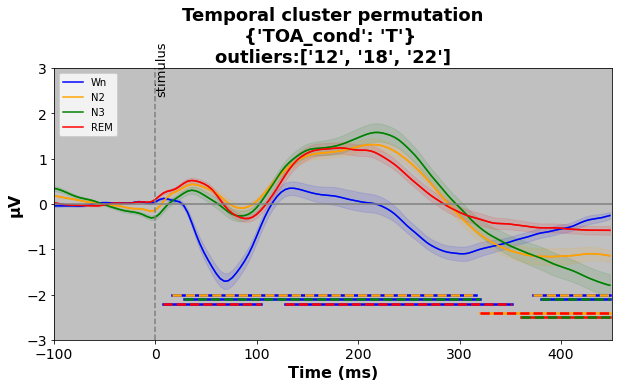

,Comparison,p-value,start (ms),end (ms)
0,Wn_N2,0.352,0,12
1,Wn_REM,0.120,32,68
2,Wn_REM,0.004,116,284
3,Wn_REM,0.005,296,448
4,N2_REM,0.036,0,72
5,N2_REM,0.006,132,312
6,N2_REM,0.008,336,448
7,REM_N3,0.082,152,220
8,REM_N3,0.312,244,252
9,REM_N3,0.264,416,432


,Comparison,p-value,start (ms),end (ms)
2,Wn_REM,0.004,116,284
3,Wn_REM,0.005,296,448
4,N2_REM,0.036,0,72
5,N2_REM,0.006,132,312
6,N2_REM,0.008,336,448


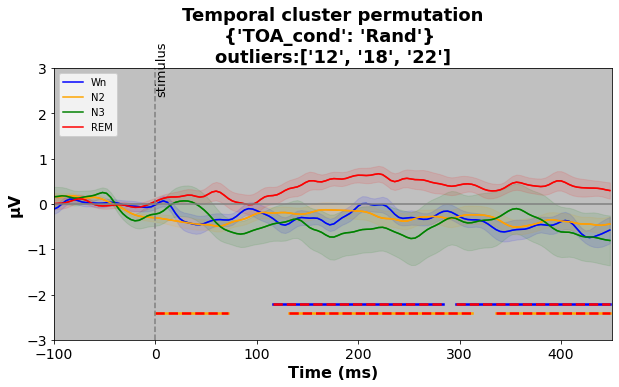

,Comparison,p-value,start (ms),end (ms)
0,Wn_N2,0.450,188,188
1,Wn_N2,0.458,212,212
2,Wn_REM,0.471,296,296
3,Wn_REM,0.158,360,396
4,N2_REM,0.012,208,316


,Comparison,p-value,start (ms),end (ms)
4,N2_REM,0.012,208,316


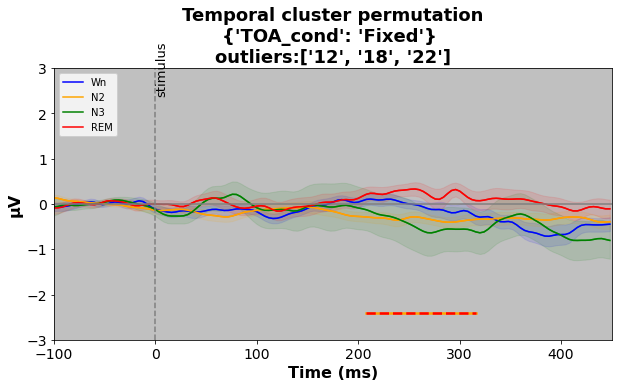

In [20]:
for TOA_cond in ['T','Rand','Fixed']:
    filters= {'TOA_cond':TOA_cond}
    filters_string = f"{filters}"

    ### get df cluster info
    with io.capture_output() as captured: # suppress output
        cluster_res = getClustersPerConditions(time0_i,contrastTypeName,contrasts,filters)
        all_clust_df, sig_clust_df = get_clusters_dfs(contrasts,times[time0_i:],cluster_res)
    display(all_clust_df)
    display(sig_clust_df)

    ### plot clusters
    fig,ax1 = plt.subplots(1, 1, figsize=(10, 5))
    ax1 = get_evokedPerCond_ax(ax1, allEvents_df, contrastTypeName, contrast_seperateVal, filters, contrasts_sep_colors)
    get_contrasts_ax(ax1, contrasts, contrastsColors,cluster_res)
    applyDesign(ax1,f'Temporal cluster permutation\n{filters_string} \noutliers:{cfg["outlier_subs"]}')

    plt.savefig(f'{fig_output_dir}/{TOA_cond}_allValidSubs_perVigi_5CentElect.png')
    plt.show()

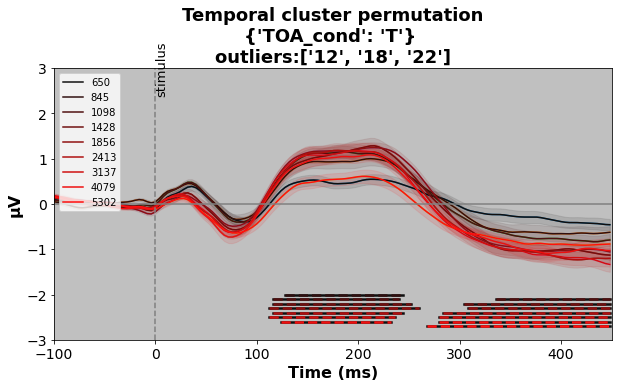

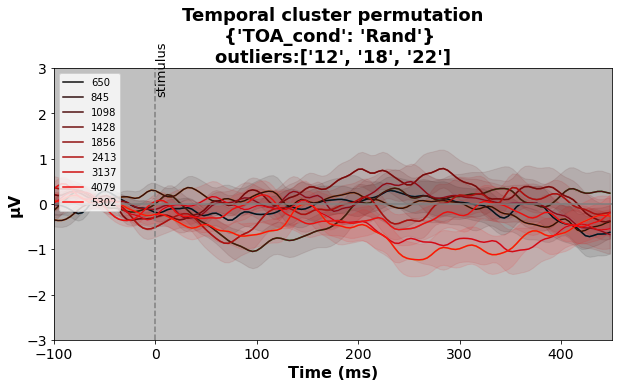

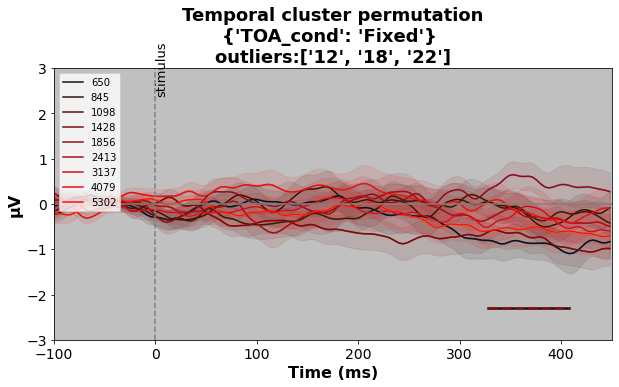

In [21]:
contrasts_sep_colors = ['#0f0f0f','#2f0f0f','#4f0f0f','#6f0f0f','#8f0f0f','#af0f0f','#cf0f0f','#ef0f0f','#ff0f0f']
contrastsColors = [[contrasts_sep_colors[0], contrasts_sep_colors[1]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[2]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[3]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[4]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[5]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[6]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[7]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[8]]]
contrastTypeName = 'ToneHeight'
contrasts = [['650','845'],['650','1098'],['650','1428'],['650','1856'],['650','2413'],['650','3137'],['650','4079'],['650','5302']]
contrast_seperateVal = ['650','845','1098','1428','1856','2413','3137','4079','5302']

for TOA_cond in ['T','Rand','Fixed']:
    filters= {'TOA_cond':TOA_cond}
    filters_string = f"{filters}"

    ### get df cluster info
    with io.capture_output() as captured: # suppress output
        cluster_res = getClustersPerConditions(time0_i,contrastTypeName,contrasts,filters)
        all_clust_df, sig_clust_df = get_clusters_dfs(contrasts,times[time0_i:],cluster_res)
        display(all_clust_df)
        display(sig_clust_df)
    ### plot clusters
    fig,ax1 = plt.subplots(1, 1, figsize=(10, 5))
    ax1 = get_evokedPerCond_ax(ax1, allEvents_df, contrastTypeName, contrast_seperateVal, filters, contrasts_sep_colors)
    get_contrasts_ax(ax1, contrasts, contrastsColors,cluster_res)
    applyDesign(ax1,f'Temporal cluster permutation\n{filters_string} \noutliers:{cfg["outlier_subs"]}')
    plt.savefig(f'{fig_output_dir}/{TOA_cond}_allValidSubs_perToneH_5CentElect.png')

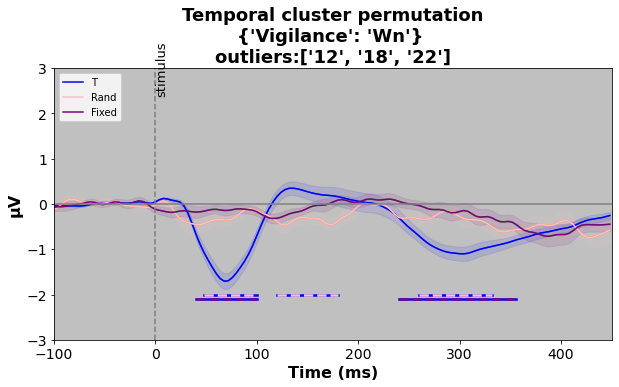

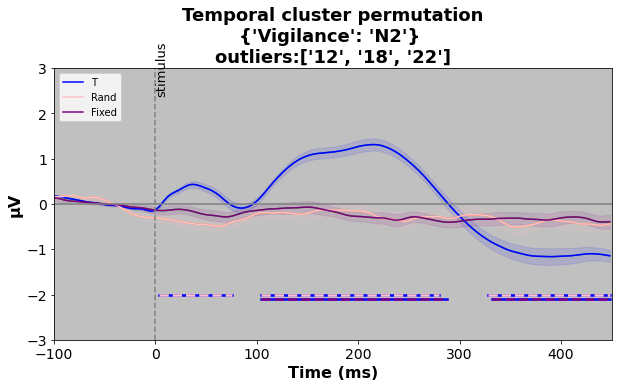

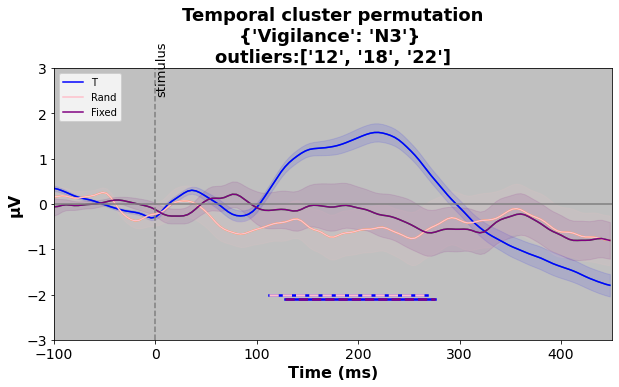

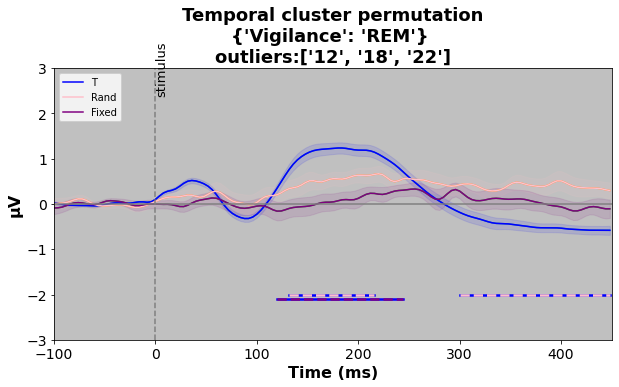

In [22]:
contrasts = [['T','Rand'],['T','Fixed'],['Rand','Fixed']]
contrastsColors = [ ['blue', 'pink'], ['blue', 'purple'],['purple', 'pink']]
contrastTypeName = 'TOA_cond'
contrast_seperateVal = ['T','Rand','Fixed']
contrasts_sep_colors = ['blue','pink','purple']

for vigilance in cfg['vigi_states']:
    filters= {'Vigilance':vigilance}
    filters_string = f"{filters}"

    ### get df cluster info
    with io.capture_output() as captured: # suppress output
        cluster_res = getClustersPerConditions(time0_i,contrastTypeName,contrasts,filters)
        all_clust_df, sig_clust_df = get_clusters_dfs(contrasts,times[time0_i:],cluster_res)
        display(all_clust_df)
        display(sig_clust_df)

    ### plot clusters
    fig,ax1 = plt.subplots(1, 1, figsize=(10, 5))
    ax1 = get_evokedPerCond_ax(ax1, allEvents_df, contrastTypeName, contrast_seperateVal, filters, contrasts_sep_colors)
    get_contrasts_ax(ax1, contrasts, contrastsColors,cluster_res)
    applyDesign(ax1,f'Temporal cluster permutation\n{filters_string} \noutliers:{cfg["outlier_subs"]}')
    plt.savefig(f'{fig_output_dir}/{vigilance}_allValidSubs_perTOACond_5CentElect.png')